In [163]:
# TẢI SPARK TRÊN GOOGLE COLAB ĐỂ CHẠY
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

!ls

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:6 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Fetched 336 kB in 5s (62.2 kB/s)
Reading package lists... Done


In [164]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [165]:
path="/content/drive/MyDrive/SE400.N12/segmentation-data.csv"

In [166]:
# Import các thư viện cần thiết
import sys
from pyspark import SparkContext, SparkConf
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col

In [167]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [168]:
# đọc dữ liệu vào dataframe
df = spark.read.option("header",True) \
     .csv(path)

In [169]:
#Xem trước tập dữ liệu
df.show()

+---------+---+--------------+---+---------+------+----------+---------------+
|       ID|Sex|Marital status|Age|Education|Income|Occupation|Settlement size|
+---------+---+--------------+---+---------+------+----------+---------------+
|100000001|  0|             0| 67|        2|124670|         1|              2|
|100000002|  1|             1| 22|        1|150773|         1|              2|
|100000003|  0|             0| 49|        1| 89210|         0|              0|
|100000004|  0|             0| 45|        1|171565|         1|              1|
|100000005|  0|             0| 53|        1|149031|         1|              1|
|100000006|  0|             0| 35|        1|144848|         0|              0|
|100000007|  0|             0| 53|        1|156495|         1|              1|
|100000008|  0|             0| 35|        1|193621|         2|              1|
|100000009|  0|             1| 61|        2|151591|         0|              0|
|100000010|  0|             1| 28|        1|174646| 

In [170]:
# Xem thống kê tập dữ liệu
df.describe().show()

+-------+-----------------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|               ID|                Sex|    Marital status|               Age|         Education|           Income|        Occupation|   Settlement size|
+-------+-----------------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|             2000|               2000|              2000|              2000|              2000|             2000|              2000|              2000|
|   mean|    1.000010005E8|              0.457|            0.4965|            35.909|             1.038|       120954.419|            0.8105|             0.739|
| stddev|577.4945887192364|0.49827215211045495|0.5001127936807873|11.719402339522171|0.5997798495564574|38108.82467857851|0.6385872272629721|0.8125325252273146|
|    min|        100000001|       

In [171]:
# Tiến hành xóa các cột không chọn để phân tích
df= df.drop(col('ID'))

In [172]:
# Tiến hành loại bỏ các dòng có education = 0 (0: không xác định được học vấn)
df = df.filter((df.Education != '0'))

In [173]:
# xem tóm tắt của tập dữ liệu
# Chuyển dữ liệu thành kiểu int để có thể xem describe chính xác hơn
df = df.withColumn("Sex", col("Sex").cast("int")) \
    .withColumn("Marital status", col("Marital status").cast("int")) \
    .withColumn("Age", col("Age").cast("int")) \
    .withColumn("Education", col("Education").cast("int")) \
    .withColumn("Income", col("Income").cast("int")) \
    .withColumn("Occupation", col("Occupation").cast("int")) \
    .withColumn("Settlement size", col("Settlement size").cast("int")) 
df.describe().show()

+-------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+
|summary|                Sex|    Marital status|               Age|          Education|            Income|        Occupation|   Settlement size|
+-------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+
|  count|               1713|              1713|              1713|               1713|              1713|              1713|              1713|
|   mean| 0.5148861646234676|0.5796847635726795|37.333333333333336| 1.2119089316987741|121940.60770577933|0.8166958552247519|0.7256275539988325|
| stddev|0.49992429497091123|0.4937536405711809|12.019762413355776|0.45733703100232287| 37694.64381283668|0.6441879344895582|0.8041383000426446|
|    min|                  0|                 0|                18|                  1|             35832|                 0|     

In [174]:
# kiểm tra lại các cột của data
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1713 entries, 0 to 1712
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Sex              1713 non-null   int32
 1   Marital status   1713 non-null   int32
 2   Age              1713 non-null   int32
 3   Education        1713 non-null   int32
 4   Income           1713 non-null   int32
 5   Occupation       1713 non-null   int32
 6   Settlement size  1713 non-null   int32
dtypes: int32(7)
memory usage: 47.0 KB


In [175]:
# Xuất ra file đã xử lý, bỏ header
df.toPandas().to_csv(r'mydata.csv', index = False, header = False)

In [176]:
# đọc dữ liệu vào RDD
fileRDD = sc.textFile("mydata.csv",minPartitions=20)

In [177]:
# gắn số dòng cho từng dòng trong data, chuyển dữ liệu sang int *, thêm vào array
# key là số dòng, bắt đầu từ 0, giá trị là giá trị chuyển sang int * trong array
fileRDD=fileRDD.zipWithIndex().map(lambda x:(x[1],np.array([int(y) for y in x[0].split(',')])))

In [178]:
# function: gắn cluster gần nhất cho từng dataPoint
# Đây là bước tìm tâm cụm cho việc khởi tạo
# x là mỗi dòng của RDD

def clust_assn(x):
  # Temp là id của cụm
  temp=0
  # dis: khoảng cách từ datapoint tới cluster gần nhất
  dist=np.inf
  # lặp qua từng tâm cụm và gắn tâm cụm gần nhất cho dataPoint
  for i in clus_bd.value:
    # Tính khoảng cách
    d = np.square(np.sqrt(sum(np.square(np.subtract(x[1], i[1])))))
    # So sánh lấy khoảng cách ngắn hơn
    if d < dist:
      # Gắn lại các giá trị tâm cụm
      dist = d
      temp=i[0]
  return (temp,(dist,x[0],x[1]))

In [179]:
# hàm khởi tạo k tâm cụm
def generate_initial_centroids(k):
  # Lấy tâm cụm đầu tiên
  # Lấy ngẫu nhiên một dòng dữ liệu để tạo thành tâm đầu tiên
  first_centroid=random.sample(range(fileRDD.count()),1)
  # Lấy giá trị tọa độ
  first_centroid_cord=fileRDD.filter(lambda x:x[0] in first_centroid)
  # Khai báo và thông báo biến ra ngoài
  global clus_bd
  clus_bd=sc.broadcast(first_centroid_cord.collect())
  for i in range(k-1):
    l = []
    bla=fileRDD.map(lambda x:clust_assn(x))
    next_full = bla.max(key=lambda x: x[1][0]) # tìm điểm ở xa nhất
    next = (next_full[1][1], next_full[1][2])
    # Ghi các giá trị tâm cụm, giải phóng tài nguyên và thông báo ra toàn cụm máy 
    clus_bd.value.append(next)
    l = clus_bd.value
    clus_bd.unpersist()
    clus_bd = sc.broadcast(l)
    first_centroid.append(next[0])

In [180]:
# Tính khoảng cách Mahattan và gắn dataPoint vào cluster
def man_distance_assign_cluster(x,n):
  temp=0
  dist=np.inf
  # Duyệt qua tất cả n tâm
  for i in range(n):
    # Tính khoảng cách Mahattan d
    d = np.sqrt(sum(np.absolute(np.subtract(x[1], centroid_centres_bd.value[i][1]))))
    # So sánh lấy khoảng cách ngắn nhất
    if d < dist:
      # Gắn Datapoint vào Cluster
      dist = d
      temp=centroid_centres_bd.value[i][0]
      # Tính chi phí cost
      cost=dist**2
  return (temp,(x[0],x[1],cost))

In [181]:
def kmeans(n_clus, n_iter):
  # khởi tạo các tâm cụm
  generate_initial_centroids(n_clus)
  cf=[]
  # khởi tạo và gắn các giá trị global sẽ được broadcast
  global centroid_centres_bd
  global label
  centroid_centres_bd=sc.broadcast(clus_bd.value)
  # Chạy các vòng lặp lại thuật toán
  for i in range(n_iter):
    # tính khoảng cách và gắn datapoin vào cluster Mahattan
    assign_cluster=fileRDD.map(lambda x: man_distance_assign_cluster(x,n_clus))
    # tính và nạp giá trị cost_func
    cost_func=round(assign_cluster.map(lambda x:x[1][2]).sum(),2)
    cf.append(cost_func)
    
    assign_cluster=assign_cluster.map(lambda x:(x[0],x[1][1]))
    # Đưa giá trị label ra ngoài
    label=sc.broadcast(assign_cluster.collect())
    # Tính toán các giá trị tâm các cụm
    new_clusters=assign_cluster.mapValues(lambda v: (v, 1)) \
      .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])) \
      .mapValues(lambda v: v[0]/v[1])
    new_clusters=new_clusters.map(lambda x:x[1]).zipWithIndex().map(lambda x:(x[1],x[0]))
    # giải phóng tài nguyên và thông báo ra ngoài giá trị tâm cụm
    centroid_centres_bd.unpersist()
    centroid_centres_bd=sc.broadcast(new_clusters.collect())  
  return cf

In [182]:
# chạy thuật toán kmeans sử dụng khoảng cách Mahattan
costs_man = kmeans(6, 20)
kmpp_centroids_man=[x[1] for x in centroid_centres_bd.value]

In [183]:
# in các nhãn cụm của dữ liệu ra 
with open('label.csv', "w") as output:
     output.write('label')
     for x in label.value:
        output.write('\n'+str(x[0]))

In [184]:
# Chi phí thuật toán sử dụng Mahattan
costs_man[19]

13061706.21

In [185]:
# In ra tâm các cụm có kmeans sử dụng khoảng cách Mahattan
with open('output_tman.txt', "w") as output:
    output.write(str(kmpp_centroids_man))

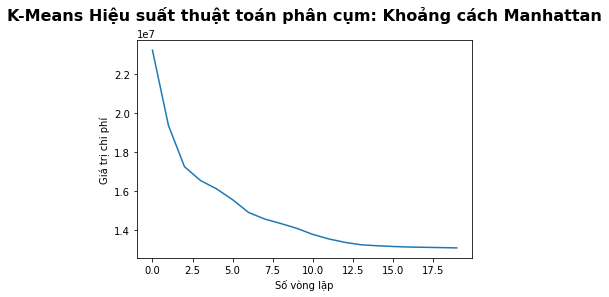

In [186]:
plt.xlabel('Số vòng lặp')
plt.ylabel('Giá trị chi phí')
plt.title('K-Means Hiệu suất thuật toán phân cụm: Khoảng cách Manhattan',pad=20, fontsize=16, fontweight='bold')
plt.plot(range(20),costs_man)

In [187]:
per_chan_m=round(((costs_man[0]-costs_man[19])/costs_man[0])*100,2)
print("Chi phí giảm thiểu khi sử dụng khoảng cách Mahattan sau 20 vòng lặp: %" + str(per_chan_m))

Chi phí giảm thiểu khi sử dụng khoảng cách Mahattan sau 20 vòng lặp: %43.81


In [188]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

# Gán nhãn dữ liệu cho dataframe ban đầu
df2 = spark.read.option("header",True) \
     .csv(path)
# Tiến hành loại bỏ các dòng có education = 0 (0: không xác định được học vấn)
df2 = df2.filter((df2.Education != '0'))

df3 = spark.read.option("header",True) \
     .csv("label.csv")
# Sử dụng row_index để thay thế cho các id dòng
df2=df2.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
df3=df3.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
# Join dữ liệu dựa trên Row_index sau đó xóa Row_index
df2 = df2.join(df3, on=["row_index"]).drop("row_index")

# Cắt bỏ những cột dữ liệu không dùng tới
newdf= df2.drop(col('ID'))

newdf.show(n=5)

+---+--------------+---+---------+------+----------+---------------+-----+
|Sex|Marital status|Age|Education|Income|Occupation|Settlement size|label|
+---+--------------+---+---------+------+----------+---------------+-----+
|  0|             0| 67|        2|124670|         1|              2|    2|
|  1|             1| 22|        1|150773|         1|              2|    1|
|  0|             0| 49|        1| 89210|         0|              0|    3|
|  0|             0| 45|        1|171565|         1|              1|    1|
|  0|             0| 53|        1|149031|         1|              1|    1|
+---+--------------+---+---------+------+----------+---------------+-----+
only showing top 5 rows



In [189]:
#import thư viện visualize
import seaborn as sns

In [190]:
#đưa dataframe tổng về pandas
newdf_pandas = newdf.toPandas()
newdf_pandas.info()
#đưa tên cột Age và Income vào một biến để visualize lên boxplot
num_columns = ['Age','Income']

#đưa tên các cột vào một các tên cột còn lại để visualize lên plt 
cat_cols = ["Sex", "Marital status", "Education", "Occupation", "Settlement size"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1713 entries, 0 to 1712
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Sex              1713 non-null   object
 1   Marital status   1713 non-null   object
 2   Age              1713 non-null   object
 3   Education        1713 non-null   object
 4   Income           1713 non-null   object
 5   Occupation       1713 non-null   object
 6   Settlement size  1713 non-null   object
 7   label            1713 non-null   object
dtypes: object(8)
memory usage: 107.2+ KB


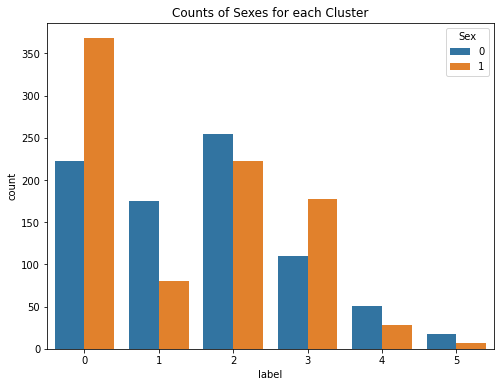

In [191]:
#phân loại khách hàng theo giới tính trên mỗi cụm
figure_size=(8, 6)
fig, axs = plt.subplots(figsize=figure_size)
sns.countplot(data=newdf_pandas, x="label", hue=cat_cols[0], order=["0", "1", "2", "3", "4", "5"])
axs.set_title("Counts of Sexes for each Cluster")
plt.show()

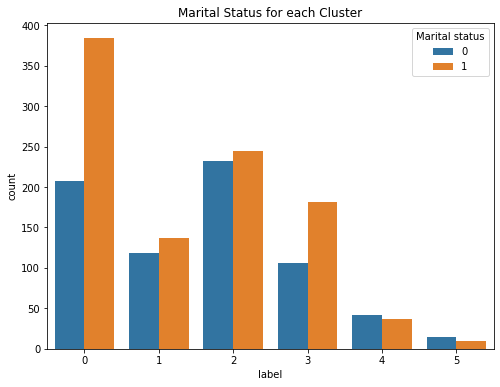

In [192]:
#phân loại khách hàng theo tình trạng hôn nhân trên mỗi cụm
fig, axs = plt.subplots(figsize=figure_size)
sns.countplot(data=newdf_pandas, x="label", hue=cat_cols[1], order=["0", "1", "2", "3", "4", "5"])
axs.set_title("Marital Status for each Cluster")
plt.show()

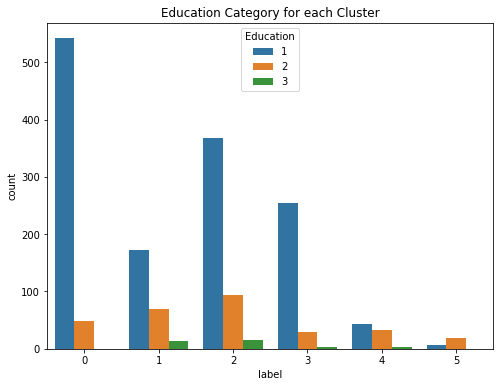

In [193]:
#Phân loại khách hàng theo trình độ văn hóa trên mỗi cụm
fig, axs = plt.subplots(figsize=figure_size)
sns.countplot(data=newdf_pandas, x="label", hue=cat_cols[2], order=["0", "1", "2", "3", "4", "5"], hue_order=["1", "2", "3"])
axs.set_title("Education Category for each Cluster")
plt.show()

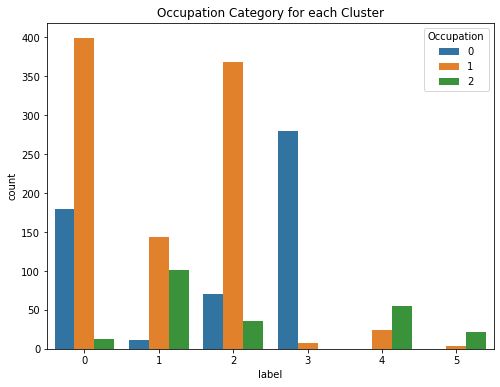

In [194]:
#phân loại khách hàng theo tình trạng nghề nghiệp trên mỗi cụm
fig, axs = plt.subplots(figsize=figure_size)
sns.countplot(data=newdf_pandas, x="label", hue=cat_cols[3], order=["0", "1", "2", "3", "4", "5"], hue_order=["0", "1", "2"])
axs.set_title("Occupation Category for each Cluster")
plt.show()

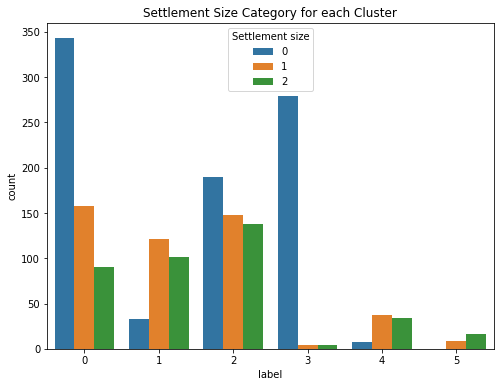

In [195]:
#phân loại khách hàng theo quy mô thành phố ở mỗi cụm
fig, axs = plt.subplots(figsize=figure_size)
sns.countplot(data=newdf_pandas, x="label", hue=cat_cols[4], order=["0", "1", "2", "3", "4", "5"], hue_order=["0", "1", "2"])
axs.set_title("Settlement Size Category for each Cluster")
plt.show()

+---+--------------+---+---------+------+----------+---------------+-----+
|Sex|Marital status|Age|Education|Income|Occupation|Settlement size|label|
+---+--------------+---+---------+------+----------+---------------+-----+
|  1|             1| 25|        1|108469|         1|              0|    0|
|  1|             1| 22|        1|108687|         1|              2|    0|
|  1|             1| 28|        1|102899|         1|              1|    0|
|  0|             1| 26|        1|103667|         1|              2|    0|
|  1|             1| 23|        1|115240|         0|              0|    0|
|  0|             1| 27|        1|106955|         1|              2|    0|
|  1|             1| 29|        1|111069|         1|              0|    0|
|  0|             0| 37|        1|106978|         1|              2|    0|
|  1|             1| 25|        1|110019|         1|              2|    0|
|  1|             1| 58|        2|100210|         0|              0|    0|
+---+--------------+---+-

<Figure size 576x288 with 0 Axes>

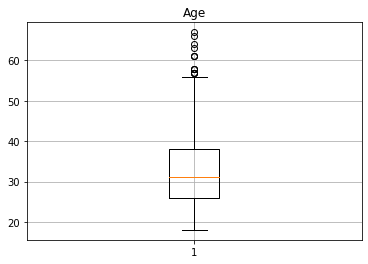

*******************************************
Income
count       591
unique      587
top       95228
freq          2
Name: Income, dtype: object
*******************************************


<Figure size 576x288 with 0 Axes>

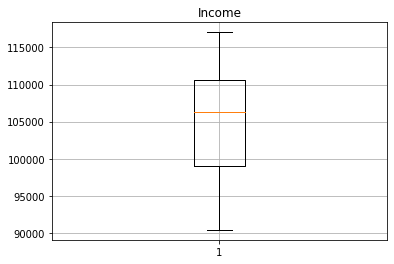

*******************************************


In [196]:
# Cụm 0
cluster_zero = newdf.filter(newdf.label == '0')
# In ra 10 dòng dữ liệu của cụm
cluster_zero.show(n=10)

# In ra các thống kê dữ liệu trong cụm
cluster_zero.describe().show()

#chuyển qua pandas
cluster_zero = cluster_zero.toPandas()

#chuyển cột Age và Income sang ndarray để visualize lên boxplot
Ages = []
Incomes = []

for i in range(len(cluster_zero['Age'])):
    Ages.append(cluster_zero["Age"][i])
Ages = np.asarray(Ages).astype(int)

for i in range(len(cluster_zero['Income'])):
    Incomes.append(cluster_zero["Income"][i])
Incomes = np.asarray(Incomes).astype(int)

for numerical in num_columns:
    plt.figure(figsize=(8,4))
    fig1, ax1 = plt.subplots()
    ax1.set_title(numerical)
    print(numerical)
    print(cluster_zero[num_columns][numerical].describe())
    print('*******************************************') 
    if(numerical == num_columns[0]):  
      ax1.boxplot(Ages)
    elif(numerical == num_columns[1]):
      ax1.boxplot(Incomes)
    plt.grid()
    plt.show()
    print('*******************************************')

+---+--------------+---+---------+------+----------+---------------+-----+
|Sex|Marital status|Age|Education|Income|Occupation|Settlement size|label|
+---+--------------+---+---------+------+----------+---------------+-----+
|  1|             1| 22|        1|150773|         1|              2|    1|
|  0|             0| 45|        1|171565|         1|              1|    1|
|  0|             0| 53|        1|149031|         1|              1|    1|
|  0|             0| 53|        1|156495|         1|              1|    1|
|  0|             1| 61|        2|151591|         0|              0|    1|
|  0|             1| 28|        1|174646|         2|              0|    1|
|  0|             0| 44|        1|147511|         1|              1|    1|
|  1|             1| 42|        2|163025|         1|              1|    1|
|  0|             0| 63|        2|175882|         1|              0|    1|
|  0|             1| 36|        1|159646|         1|              1|    1|
+---+--------------+---+-

<Figure size 576x288 with 0 Axes>

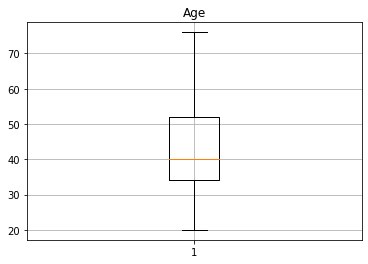

*******************************************
Income
count        255
unique       251
top       145174
freq           2
Name: Income, dtype: object
*******************************************


<Figure size 576x288 with 0 Axes>

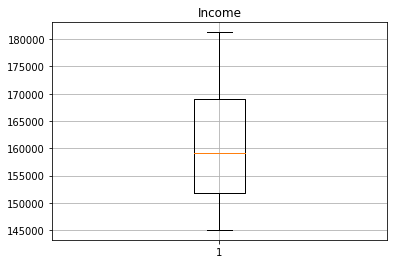

*******************************************


In [197]:
# Cụm 1
cluster_one = newdf.filter(newdf.label == '1')
# In ra 10 dòng dữ liệu của cụm
cluster_one.show(n=10)

# In ra các thống kê dữ liệu trong cụm
cluster_one.describe().show()

#chuyển qua pandas
cluster_one = cluster_one.toPandas()

#chuyển cột Age và Income sang ndarray để visualize lên boxplot
Ages = []
Incomes = []

for i in range(len(cluster_one['Age'])):
    Ages.append(cluster_one["Age"][i])
Ages = np.asarray(Ages).astype(int)

for i in range(len(cluster_one['Income'])):
    Incomes.append(cluster_one["Income"][i])
Incomes = np.asarray(Incomes).astype(int)

for numerical in num_columns:
    plt.figure(figsize=(8,4))
    fig1, ax1 = plt.subplots()
    ax1.set_title(numerical)
    print(numerical)
    print(cluster_one[num_columns][numerical].describe())
    print('*******************************************') 
    if(numerical == num_columns[0]):  
      ax1.boxplot(Ages)
    elif(numerical == num_columns[1]):
      ax1.boxplot(Incomes)
    plt.grid()
    plt.show()
    print('*******************************************')

+---+--------------+---+---------+------+----------+---------------+-----+
|Sex|Marital status|Age|Education|Income|Occupation|Settlement size|label|
+---+--------------+---+---------+------+----------+---------------+-----+
|  0|             0| 67|        2|124670|         1|              2|    2|
|  0|             0| 35|        1|144848|         0|              0|    2|
|  1|             1| 24|        1|127596|         1|              0|    2|
|  0|             0| 53|        1|125550|         1|              0|    2|
|  0|             0| 48|        1|118777|         1|              1|    2|
|  0|             0| 44|        1|134918|         1|              2|    2|
|  0|             0| 34|        1|119307|         1|              1|    2|
|  0|             0| 37|        1|127676|         1|              1|    2|
|  0|             0| 37|        1|119276|         1|              1|    2|
|  0|             1| 26|        1|130921|         1|              0|    2|
+---+--------------+---+-

<Figure size 576x288 with 0 Axes>

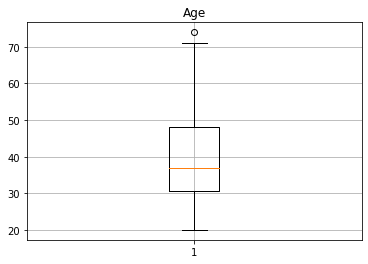

*******************************************
Income
count        476
unique       470
top       136812
freq           2
Name: Income, dtype: object
*******************************************


<Figure size 576x288 with 0 Axes>

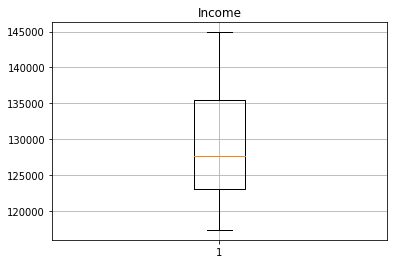

*******************************************


In [198]:
# Cụm 2
cluster_two = newdf.filter(newdf.label == '2')
# In ra 10 dòng dữ liệu của cụm
cluster_two.show(n=10)

# In ra các thống kê dữ liệu trong cụm
cluster_two.describe().show()

#chuyển qua pandas
cluster_two = cluster_two.toPandas()

#chuyển cột Age và Income sang ndarray để visualize lên boxplot
Ages = []
Incomes = []

for i in range(len(cluster_two['Age'])):
    Ages.append(cluster_two["Age"][i])
Ages = np.asarray(Ages).astype(int)

for i in range(len(cluster_two['Income'])):
    Incomes.append(cluster_two["Income"][i])
Incomes = np.asarray(Incomes).astype(int)

for numerical in num_columns:
    plt.figure(figsize=(8,4))
    fig1, ax1 = plt.subplots()
    ax1.set_title(numerical)
    print(numerical)
    print(cluster_two[num_columns][numerical].describe())
    print('*******************************************') 
    if(numerical == num_columns[0]):  
      ax1.boxplot(Ages)
    elif(numerical == num_columns[1]):
      ax1.boxplot(Incomes)
    plt.grid()
    plt.show()
    print('*******************************************')

+---+--------------+---+---------+------+----------+---------------+-----+
|Sex|Marital status|Age|Education|Income|Occupation|Settlement size|label|
+---+--------------+---+---------+------+----------+---------------+-----+
|  0|             0| 49|        1| 89210|         0|              0|    3|
|  0|             0| 60|        2| 89374|         0|              0|    3|
|  1|             1| 32|        1| 88428|         0|              0|    3|
|  0|             0| 48|        1| 89804|         0|              0|    3|
|  0|             0| 36|        1| 71909|         0|              0|    3|
|  0|             1| 39|        1| 68264|         0|              0|    3|
|  0|             0| 57|        2| 87605|         0|              0|    3|
|  1|             1| 23|        1| 65421|         0|              0|    3|
|  0|             0| 46|        1| 73703|         0|              0|    3|
|  1|             1| 24|        1| 84792|         0|              0|    3|
+---+--------------+---+-

<Figure size 576x288 with 0 Axes>

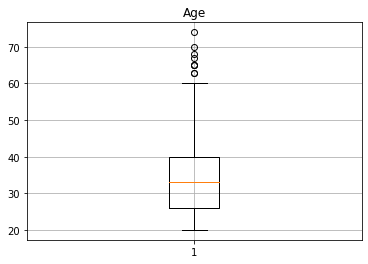

*******************************************
Income
count       287
unique      285
top       69487
freq          2
Name: Income, dtype: object
*******************************************


<Figure size 576x288 with 0 Axes>

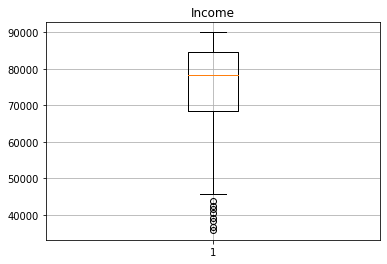

*******************************************


In [199]:
# Cụm 3
cluster_three = newdf.filter(newdf.label == '3')
# In ra 10 dòng dữ liệu của cụm
cluster_three.show(n=10)

# In ra các thống kê dữ liệu trong cụm
cluster_three.describe().show()

#chuyển qua pandas
cluster_three = cluster_three.toPandas()

#chuyển cột Age và Income sang ndarray để visualize lên boxplot
Ages = []
Incomes = []

for i in range(len(cluster_three['Age'])):
    Ages.append(cluster_three["Age"][i])
Ages = np.asarray(Ages).astype(int)

for i in range(len(cluster_three['Income'])):
    Incomes.append(cluster_three["Income"][i])
Incomes = np.asarray(Incomes).astype(int)

for numerical in num_columns:
    plt.figure(figsize=(8,4))
    fig1, ax1 = plt.subplots()
    ax1.set_title(numerical)
    print(numerical)
    print(cluster_three[num_columns][numerical].describe())
    print('*******************************************') 
    if(numerical == num_columns[0]):  
      ax1.boxplot(Ages)
    elif(numerical == num_columns[1]):
      ax1.boxplot(Incomes)
    plt.grid()
    plt.show()
    print('*******************************************')

+---+--------------+---+---------+------+----------+---------------+-----+
|Sex|Marital status|Age|Education|Income|Occupation|Settlement size|label|
+---+--------------+---+---------+------+----------+---------------+-----+
|  0|             0| 35|        1|193621|         2|              1|    4|
|  0|             0| 52|        1|202575|         2|              2|    4|
|  1|             1| 31|        1|183657|         1|              1|    4|
|  0|             0| 36|        1|195465|         2|              2|    4|
|  0|             0| 39|        1|183108|         2|              2|    4|
|  1|             1| 30|        1|189896|         2|              0|    4|
|  1|             1| 21|        1|194728|         1|              0|    4|
|  1|             1| 29|        1|214204|         1|              2|    4|
|  0|             0| 36|        1|208101|         2|              2|    4|
|  0|             0| 70|        2|224998|         2|              2|    4|
+---+--------------+---+-

<Figure size 576x288 with 0 Axes>

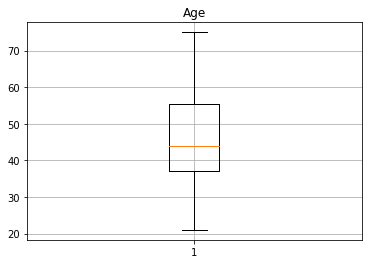

*******************************************
Income
count         79
unique        78
top       214364
freq           2
Name: Income, dtype: object
*******************************************


<Figure size 576x288 with 0 Axes>

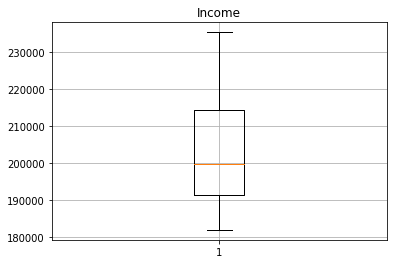

*******************************************


In [200]:
# Cụm 4
cluster_four = newdf.filter(newdf.label == '4')
# In ra 10 dòng dữ liệu của cụm
cluster_four.show(n=10)

# In ra các thống kê dữ liệu trong cụm
cluster_four.describe().show()

#chuyển qua pandas
cluster_four = cluster_four.toPandas()

#chuyển cột Age và Income sang ndarray để visualize lên boxplot
Ages = []
Incomes = []

for i in range(len(cluster_four['Age'])):
    Ages.append(cluster_four["Age"][i])
Ages = np.asarray(Ages).astype(int)

for i in range(len(cluster_four['Income'])):
    Incomes.append(cluster_four["Income"][i])
Incomes = np.asarray(Incomes).astype(int)

for numerical in num_columns:
    plt.figure(figsize=(8,4))
    fig1, ax1 = plt.subplots()
    ax1.set_title(numerical)
    print(numerical)
    print(cluster_four[num_columns][numerical].describe())
    print('*******************************************') 
    if(numerical == num_columns[0]):  
      ax1.boxplot(Ages)
    elif(numerical == num_columns[1]):
      ax1.boxplot(Incomes)
    plt.grid()
    plt.show()
    print('*******************************************')

+---+--------------+---+---------+------+----------+---------------+-----+
|Sex|Marital status|Age|Education|Income|Occupation|Settlement size|label|
+---+--------------+---+---------+------+----------+---------------+-----+
|  1|             1| 44|        2|261952|         2|              2|    5|
|  0|             0| 47|        1|241068|         1|              1|    5|
|  0|             0| 58|        2|268340|         1|              1|    5|
|  0|             0| 39|        1|244716|         2|              2|    5|
|  0|             0| 36|        1|244541|         2|              2|    5|
|  0|             0| 63|        2|272314|         2|              2|    5|
|  1|             1| 60|        2|309364|         2|              2|    5|
|  0|             0| 57|        2|281923|         2|              1|    5|
|  1|             1| 38|        1|260977|         2|              2|    5|
|  0|             0| 48|        1|254449|         2|              1|    5|
+---+--------------+---+-

<Figure size 576x288 with 0 Axes>

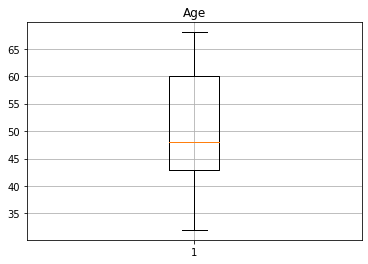

*******************************************
Income
count         25
unique        25
top       261952
freq           1
Name: Income, dtype: object
*******************************************


<Figure size 576x288 with 0 Axes>

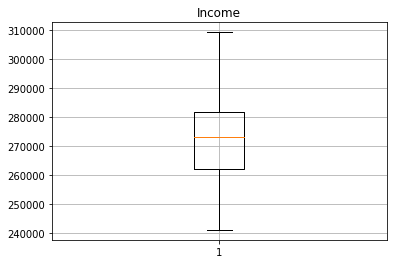

*******************************************


In [201]:
# Cụm 5
cluster_five = newdf.filter(newdf.label == '5')
# In ra 10 dòng dữ liệu của cụm
cluster_five.show(n=10)

# In ra các thống kê dữ liệu trong cụm
cluster_five.describe().show()

#chuyển qua pandas
cluster_five = cluster_five.toPandas()

#chuyển cột Age và Income sang ndarray để visualize lên boxplot
Ages = []
Incomes = []

for i in range(len(cluster_five['Age'])):
    Ages.append(cluster_five["Age"][i])
Ages = np.asarray(Ages).astype(int)

for i in range(len(cluster_five['Income'])):
    Incomes.append(cluster_five["Income"][i])
Incomes = np.asarray(Incomes).astype(int)

for numerical in num_columns:
    plt.figure(figsize=(8,4))
    fig1, ax1 = plt.subplots()
    ax1.set_title(numerical)
    print(numerical)
    print(cluster_five[num_columns][numerical].describe())
    print('*******************************************') 
    if(numerical == num_columns[0]):  
      ax1.boxplot(Ages)
    elif(numerical == num_columns[1]):
      ax1.boxplot(Incomes)
    plt.grid()
    plt.show()
    print('*******************************************')